<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C8NP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.simplefilter('ignore')
from sklearn.manifold import isomap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [0]:
features = ['T10','T50','T90','N+A']
y_name = 'C8NP'

In [3]:
train_4521 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]
for i in [train_4521,test_170,test_250,test_200,test_50]:
  print(i.shape)

(4521, 27)
(170, 27)
(250, 27)
(200, 27)
(50, 27)


In [4]:
full = pd.DataFrame()
for tag ,data in zip(['train_4521','test_170','test_200','test_50'],[train_4521,test_170,test_200,test_50]):
  data['tag'] = tag
  full = full.append(data)
print(full['tag'].value_counts())

train_4521    4521
test_200       200
test_170       170
test_50         50
Name: tag, dtype: int64


# scaler features

In [5]:
scaler = StandardScaler()
full[features] = scaler.fit_transform(full[features])
full.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,tag
0,0.457412,0.553030,0.441672,-1.055733,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319,train_4521
1,0.379268,0.363497,0.228433,-1.104130,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303,train_4521
2,0.413999,0.494712,0.249757,-1.130572,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289,train_4521
3,0.448730,0.465553,-0.325989,-1.117705,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281,train_4521
4,0.448730,0.392656,-0.475256,-1.030708,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290,train_4521


# corr with x

In [6]:
corr_x = abs(full.corr()[features+[y_name]].loc[features,y_name])
corr_x

T10    0.751300
T50    0.751773
T90    0.185074
N+A    0.744719
Name: C8NP, dtype: float64

In [7]:
best_t = corr_x.drop('N+A').argmax()
best_t

'T50'

# isomap

In [0]:
iso_col = [best_t,'N+A']
iso = isomap.Isomap(n_components=1)
full['ISO'] = iso.fit_transform(full[iso_col])
features = features + ['ISO']

# corr

In [9]:
abs(full.corr())[[y_name]].loc[features].sort_values(by=y_name,ascending=False)

,C8NP
ISO,0.903036
T50,0.751773
T10,0.751300
N+A,0.744719
T90,0.185074


# scatter

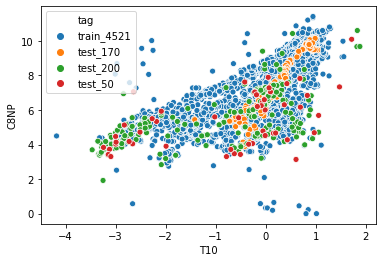

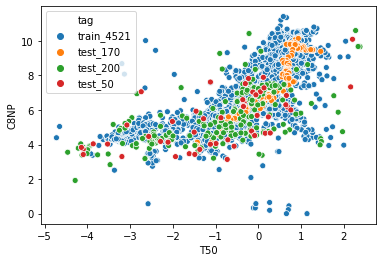

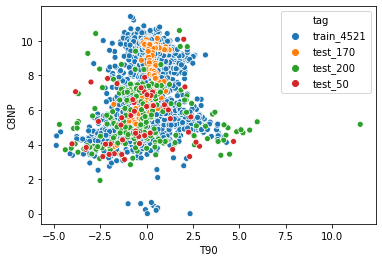

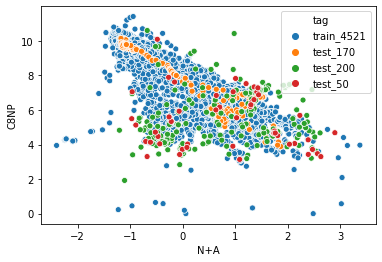

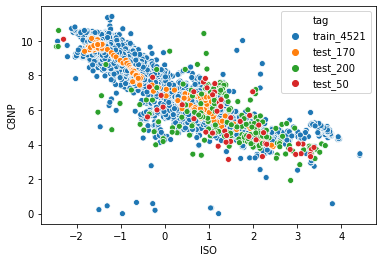

In [10]:
for x_col in features:
  sns.scatterplot(x = x_col,y = y_name,data=full,hue='tag')
  plt.show()

# features select

In [0]:
features = ['ISO']

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()
def metric(y_t,y_p,name):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'MAPE':mape_vectorized_v2(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

# split

In [0]:
train_4521 = full[full.tag=='train_4521']
test_170 = full[full.tag=='test_170']
test_200 = full[full.tag=='test_200']
test_50 = full[full.tag=='test_50']

# modeling

In [14]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

model = LinearRegression()
val_scores = cross_validate(model,train_4521[features],train_4521[y_name],cv=5)
print('val_scores:',val_scores['test_score'])
print('val_scores.mean:',val_scores['test_score'].mean())

val_scores: [0.72580704 0.78268332 0.81942457 0.85057605 0.79405424]
val_scores.mean: 0.794509043112094


In [15]:
model.fit(train_4521[features],train_4521[y_name])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
train_4521['y_pred'] = model.predict(train_4521[features])
test_170['y_pred'] = model.predict(test_170[features])
test_200['y_pred'] = model.predict(test_200[features])
test_50['y_pred'] = model.predict(test_50[features])

In [17]:
res = pd.DataFrame()
for name,df in zip(['train_4521','test_170','test_200','test_50'],[train_4521,test_170,test_200,test_50]):
  res = res.append(metric(df[y_name],df['y_pred'],name))
res

,R2,RMSE,MAPE
train_4521,0.819326,0.836259,0.119925
test_170,0.947037,0.397738,0.047849
test_200,0.195649,1.398690,0.207572
test_50,0.516560,1.082079,0.174824


# line plot

In [0]:
def pred_plot(df,by_col,name):
  df = df.sort_values(by = by_col)
  plt.plot(df[by_col],df['y_pred'],color='red')
  plt.scatter(df[by_col],df[y_name],label= name + '_point')

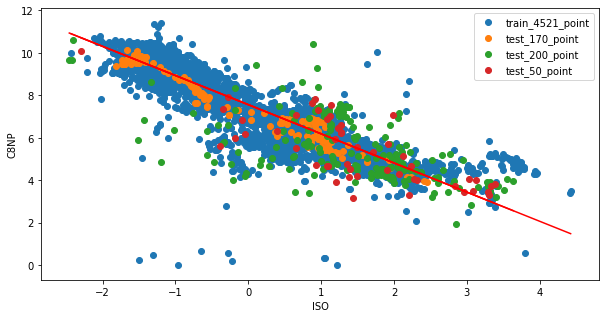

In [19]:
by_col = 'ISO'
fig = plt.figure(figsize=(10,5))
pred_plot(train_4521,by_col,name='train_4521')
pred_plot(test_170,by_col,name='test_170')
pred_plot(test_200,by_col,name='test_200')
pred_plot(test_50,by_col,name='test_50')
plt.xlabel(by_col)
plt.ylabel(y_name)
plt.legend()
plt.show()

# tag loss

In [0]:
def tag_loss(df):
  df['loss'] = (df[y_name]-df['y_pred'])**2
  return df
train_4521 = tag_loss(train_4521)
test_170 = tag_loss(test_170)
test_200 = tag_loss(test_200)
test_50 = tag_loss(test_50)

# del_out_scores:

In [21]:
res = pd.DataFrame()
for name,df in zip(['train_4521','test_170','test_200','test_50'],[train_4521,test_170,test_200,test_50]):
  t1 = len(df)
  df = df.loc[df['loss']<=0.4,:]
  t2 = len(df)
  met = metric(df[y_name],df['y_pred'],name)
  met['drop_num'] = t1-t2
  res = res.append(met)
res

,R2,RMSE,MAPE,drop_num
train_4521,0.963052,0.348236,0.040497,1405
test_170,0.965673,0.320483,0.038610,19
test_200,0.921869,0.372912,0.062614,136
test_50,0.957662,0.351516,0.059380,30
